In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
sys.path.insert(0, '../')
from scipy import misc
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import LocallyConnected2D
from keras.layers.convolutional import Conv2D
from keras.layers import *
from keras import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,TensorBoard, Callback
import matplotlib.pyplot as plt
%matplotlib nbagg
from keras.utils import np_utils
from keras import backend as K
import cv2
from common import util
from sklearn.model_selection import train_test_split
import random
import glob
import tensorflow as tf
K.set_image_dim_ordering('th')

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/dlutils/plot_image_batch_w_labels.py:16: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
   

In [2]:
def hot_vectorize(x,value = 0):
    zero_mask = x==value
    non_zero_mask = x!=value
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x.astype(float)

def stack_frames(frames,img_height,img_width,channels):
    stack  = np.zeros((1,img_height,img_width,channels))
    index = 0
    for i in frames:
        num_chan = 1 if len(np.shape(i)) ==2 else np.shape(i)[2]
        stack[0,:,:,index:index+num_chan] = np.reshape(i,(img_height,img_width,num_chan))
        index += num_chan
    return stack

def grab_frame(files,i,path,func=None):
    img = misc.imread(path+files[i])
    if func:
        return func(img)
    return img

def grab_frame1(path,func=None):
    img = misc.imread(path)
    if func:
        return func(img)
    return img

def normalize(x):
    return x.astype(float)/3500.

def normalize_depth(x):
    return x.astype(float)/3000.

def convert_rgb_normal(img):
    return (img/255.*2)-1

def bounding_box(img,size = 100):
    h,w = np.shape(img)
    non_zeros = np.nonzero(img)
    x_min = np.min(non_zeros[0])
    x_max = np.max(non_zeros[0])
    y_min = np.min(non_zeros[1])
    y_max = np.max(non_zeros[1])
    out = (x_min,x_min+size,y_min,y_min+size) if size else (x_min,x_max,y_min,y_max)#minuce or plus coordinates
    if x_min< 0 or x_min+size > h or y_min<0 or y_min+size>w:
        return None
    return out

def crop(x,x1 = 100,x2 = 500,y1 = 50, y2 = 450):
    x = x[y1:y2,x1:x2]
    return x
def flip_vert(x,y):
    y= np.flip(y,axis=0)
    x= np.flip(x,axis=0)
    return x,y
def flip_hor(x,y):
    x= np.flip(x,axis=1)
    y= np.flip(y,axis=1)
    return x,y
def rotate(x,y):
    degrees = np.random.randint(360)
    centerx = tuple(np.array(x.shape[1::-1]) / 2)
    centery = tuple(np.array(y.shape[1::-1]) / 2)
    rotx = cv2.getRotationMatrix2D(centerx, degrees, 1.0)
    roty = cv2.getRotationMatrix2D(centery, degrees, 1.0)
    x = cv2.warpAffine(x, rotx, x.shape[1::-1], flags=cv2.INTER_LINEAR)
    y = cv2.warpAffine(y, roty, y.shape[1::-1], flags=cv2.INTER_LINEAR)
    return x,y
def augment(x,y,func = [],bias_to_real = .5):
    #x = crop(x)
    #y = crop(y)
    if np.random.rand()>bias_to_real:#bias to real images
        function = np.random.choice(func)
        x,y=function(x,y)
    return x,y

In [24]:
samples = gen_samples("/media/drc/DATA/chris_labelfusion/RGBDCNN/")

In [32]:
train = generate_data_custom_depth(samples,func=[flip_hor,flip_vert,rotate],img_height=480,img_width=640)

In [31]:
def gen_samples(directory,shuffle = True):
    samples = []
    dirs = os.listdir(directory)
    for i in dirs:
        path = os.path.join(directory, i)+"/"
        if os.access(path, os.R_OK):
            gt_depth = sorted(glob.glob(path+"*_truth.png"))
            depth = sorted(glob.glob(path+"*_depth.png"))
            samples.extend(zip(gt_depth,depth))
    if shuffle:
        random.shuffle(samples)
    return samples                

In [30]:
def generate_data_custom_depth(samples,img_height=480,img_width=640,batch_size=4,func=[]):
    i = 0
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,1))
        stack2 = np.zeros((batch_size,img_height,img_width,1))
        j=0
        while j<batch_size:
            try: 
                rgb = samples[i][0]
                depth = samples[i][1]
                rgb_img = grab_frame1(rgb,normalize)
                depth_img = grab_frame1(depth,hot_vectorize)
                rgb_img,depth_img = augment(rgb_img,depth_img,func,bias_to_real = .5)
                stack1[j] = np.reshape(rgb_img,(img_height,img_width,1))
                stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
                j+=1
                i= (i+1)%len(samples)
            except Exception:
                i=(i+1)%len(samples)
        yield (stack1,stack2)

In [39]:
def generate_data_custom1(depth_as_mask=True,img_height=480,img_width=640,batch_size=4,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"
    depth_path = path+"depth/"

    rgb = np.sort(os.listdir(rgb_path))
    depth = np.sort(os.listdir(depth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            depth = np.sort(filter(lambda x: filter_files in x, depth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,3))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(rgb)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
          
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            stack = stack_frames([rgb_img],img_height,img_width,3)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [40]:
def generate_data_custom3(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,7))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            gtdepth_img[gtdepth_img==0]=1.

            stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,7)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [55]:
def generate_data_custom(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,channels =1,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,channels))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            a = bounding_box(gtdepth_img,img_height)
            while not a:
                i= (i+1)%len(depth)
                rgb_img = grab_frame(rgb,i,rgb_path,func)
                normal_img = grab_frame(normal,i,normal_path,normalize)
                gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
                depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
                a = bounding_box(gtdepth_img,img_height)

            x1,x2,y1,y2 = a
            depth_img = depth_img[x1:x2,y1:y2] 
            gtdepth_img = gtdepth_img[x1:x2,y1:y2]
            normal_img = normal_img[x1:x2,y1:y2]
            gtdepth_img[gtdepth_img==0]=1.

            #stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,4)
            stack = stack_frames([gtdepth_img],img_height,img_width,channels)

            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [56]:
gen  = generate_data_custom( func=normalize)

In [17]:
img_height=400
img_width=400

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


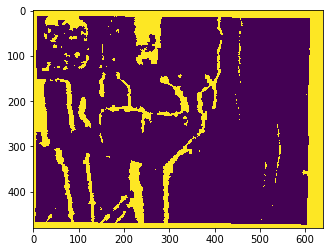

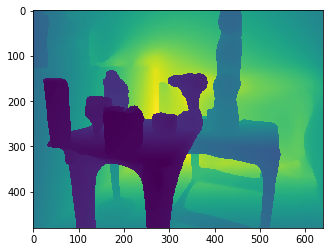

In [26]:
%matplotlib inline
now = train.next()
plt.figure()
plt.imshow(now[1][0][:,:,0])
plt.figure()
plt.imshow(now[0][0][:,:,0])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


<IPython.core.display.Javascript object>


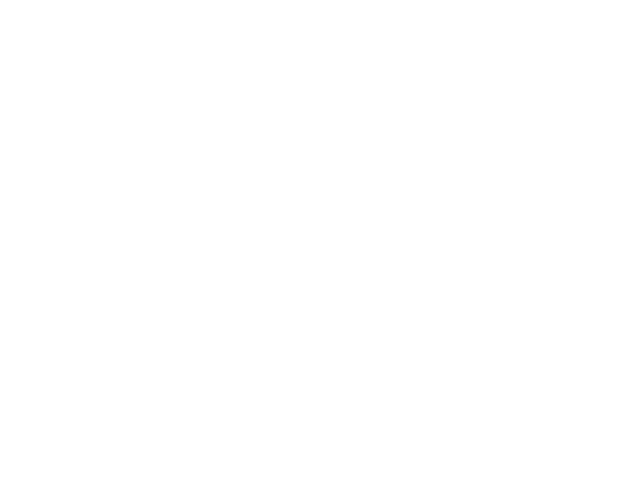

<IPython.core.display.Javascript object>


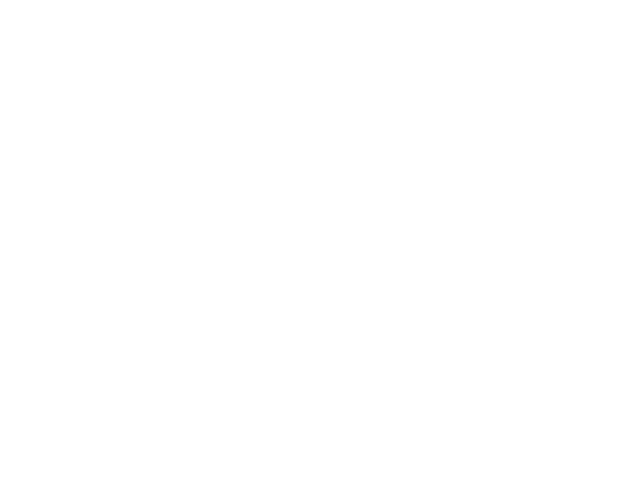

<IPython.core.display.Javascript object>


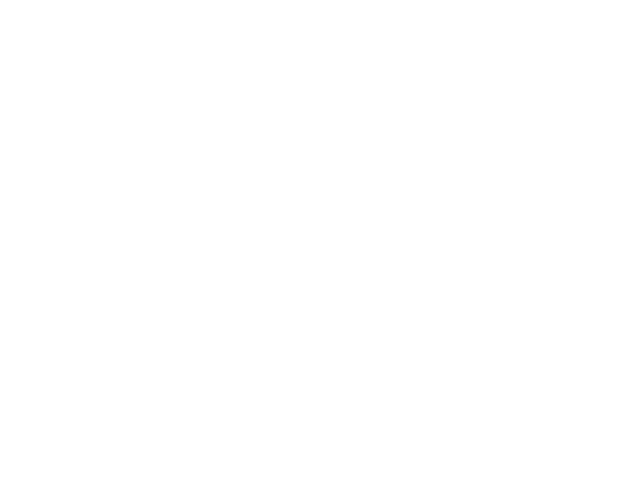

<IPython.core.display.Javascript object>


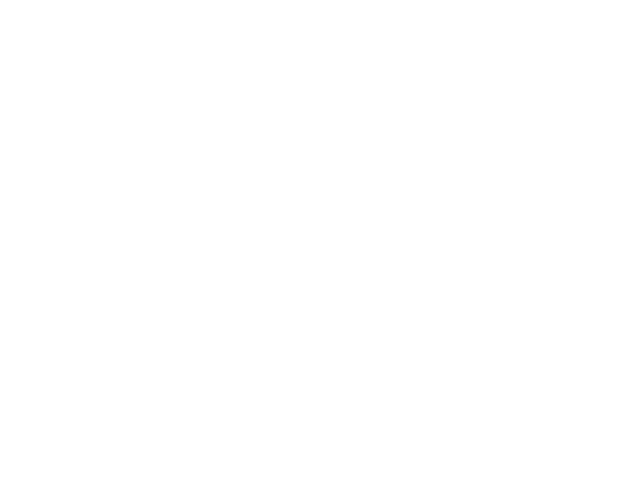

In [58]:
%matplotlib nbagg
now = gen.next()
plt.figure()
plt.imshow(np.reshape(now[1][0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,1:4],(480,640,3)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,4:],(480,640,3)))

In [22]:
#img_height = 480 #check with old params
#img_width = 640
inputs = Input((img_height, img_width,1))

In [15]:
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
import json

img_w = 640
img_h = 480
n_labels = 2

kernel = 3

encoding_layers = [
    Convolution2D(16, kernel, border_mode='same', input_shape=( img_h, img_w,1),data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(data_format='channels_last'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(1, 1, border_mode='valid',data_format='channels_last'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)


#autoencoder.add(Reshape((n_labels, img_h * img_w)))
#autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('sigmoid'))

autoencoder.summary()
autoencoder.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, 3, padding="same", data_format="channels_last", input_shape=(480, 640,...)`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipyker

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 480, 640, 16)      160       
_________________________________________________________________
batch_normalization_92 (Batc (None, 480, 640, 16)      64        
_________________________________________________________________
activation_92 (Activation)   (None, 480, 640, 16)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 480, 640, 16)      2320      
_________________________________________________________________
batch_normalization_93 (Batc (None, 480, 640, 16)      64        
_________________________________________________________________
activation_93 (Activation)   (None, 480, 640, 16)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 240, 320, 16)      0         
__________

In [21]:
batch_size =4

In [80]:
model_checkpoint = ModelCheckpoint('net_segnet_aug.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs1', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
autoencoder.fit_generator(train, nb_epoch=1000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=1000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/1000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.1189 - acc: 0.9519
Epoch 00001: loss improved from inf to 0.11924, saving model to net_segnet_aug.hdf5
100/100 [==============================] - 45s 452ms/step - loss: 0.1192 - acc: 0.9518
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1190 - acc: 0.9513
Epoch 00002: loss improved from 0.11924 to 0.11882, saving model to net_segnet_aug.hdf5
100/100 [==============================] - 44s 438ms/step - loss: 0.1188 - acc: 0.9514
Epoch 3/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1173 - acc: 0.9524
Epoch 00003: loss improved from 0.11882 to 0.11786, saving model to net_segnet_aug.hdf5
100/100 [==============================] - 43s 433ms/step - loss: 0.1179 - acc: 0.9522
Epoch 4/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1155 - acc: 0.9533
Epoch 00004: loss improved from 0.11786 to 0.11528, saving model to net_segnet_aug.hdf5
100/100 [=======================

Epoch 37/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1112 - acc: 0.9553
Epoch 00037: loss did not improve
100/100 [==============================] - 43s 431ms/step - loss: 0.1113 - acc: 0.9553
Epoch 38/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1091 - acc: 0.9559
Epoch 00038: loss did not improve
100/100 [==============================] - 43s 428ms/step - loss: 0.1091 - acc: 0.9559
Epoch 39/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1011 - acc: 0.9587
Epoch 00039: loss improved from 0.10197 to 0.10087, saving model to net_segnet_aug.hdf5
100/100 [==============================] - 43s 435ms/step - loss: 0.1009 - acc: 0.9588
Epoch 40/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1067 - acc: 0.9568
Epoch 00040: loss did not improve
100/100 [==============================] - 43s 434ms/step - loss: 0.1074 - acc: 0.9566
Epoch 41/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1124 - acc:

Epoch 75/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1119 - acc: 0.9543
Epoch 00075: loss did not improve
100/100 [==============================] - 44s 437ms/step - loss: 0.1118 - acc: 0.9543
Epoch 76/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1147 - acc: 0.9538
Epoch 00076: loss did not improve
100/100 [==============================] - 43s 432ms/step - loss: 0.1148 - acc: 0.9537
Epoch 77/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1064 - acc: 0.9561
Epoch 00077: loss did not improve
100/100 [==============================] - 43s 432ms/step - loss: 0.1062 - acc: 0.9562
Epoch 78/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1120 - acc: 0.9543
Epoch 00078: loss did not improve
100/100 [==============================] - 43s 425ms/step - loss: 0.1123 - acc: 0.9542
Epoch 79/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1044 - acc: 0.9574
Epoch 00079: loss did not improve
100/100 [===

Epoch 113/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1088 - acc: 0.9561
Epoch 00113: loss did not improve
100/100 [==============================] - 44s 436ms/step - loss: 0.1098 - acc: 0.9558
Epoch 114/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1045 - acc: 0.9573
Epoch 00114: loss did not improve
100/100 [==============================] - 44s 445ms/step - loss: 0.1051 - acc: 0.9571
Epoch 115/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1108 - acc: 0.9553
Epoch 00115: loss did not improve
100/100 [==============================] - 44s 439ms/step - loss: 0.1106 - acc: 0.9553
Epoch 116/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1174 - acc: 0.9521
Epoch 00116: loss did not improve
100/100 [==============================] - 44s 442ms/step - loss: 0.1174 - acc: 0.9520
Epoch 117/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1085 - acc: 0.9556
Epoch 00117: loss did not improve
100/100

Epoch 151/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1074 - acc: 0.9563
Epoch 00151: loss did not improve
100/100 [==============================] - 42s 425ms/step - loss: 0.1076 - acc: 0.9563
Epoch 152/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1087 - acc: 0.9553
Epoch 00152: loss did not improve
100/100 [==============================] - 44s 440ms/step - loss: 0.1090 - acc: 0.9551
Epoch 153/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1074 - acc: 0.9560
Epoch 00153: loss did not improve
100/100 [==============================] - 45s 447ms/step - loss: 0.1073 - acc: 0.9561
Epoch 154/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1077 - acc: 0.9559
Epoch 00154: loss did not improve
100/100 [==============================] - 43s 434ms/step - loss: 0.1077 - acc: 0.9559
Epoch 155/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1022 - acc: 0.9577
Epoch 00155: loss did not improve
100/100

Epoch 189/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1027 - acc: 0.9583
Epoch 00189: loss did not improve
100/100 [==============================] - 43s 431ms/step - loss: 0.1024 - acc: 0.9584
Epoch 190/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1067 - acc: 0.9573
Epoch 00190: loss did not improve
100/100 [==============================] - 43s 428ms/step - loss: 0.1068 - acc: 0.9573
Epoch 191/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1065 - acc: 0.9562
Epoch 00191: loss did not improve
100/100 [==============================] - 43s 434ms/step - loss: 0.1074 - acc: 0.9559
Epoch 192/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1125 - acc: 0.9536
Epoch 00192: loss did not improve
100/100 [==============================] - 44s 439ms/step - loss: 0.1121 - acc: 0.9537
Epoch 193/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1091 - acc: 0.9553
Epoch 00193: loss did not improve
100/100

Epoch 227/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1041 - acc: 0.9576
Epoch 00227: loss did not improve
100/100 [==============================] - 44s 436ms/step - loss: 0.1043 - acc: 0.9576
Epoch 228/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1116 - acc: 0.9542
Epoch 00228: loss did not improve
100/100 [==============================] - 43s 430ms/step - loss: 0.1114 - acc: 0.9543
Epoch 229/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1116 - acc: 0.9546
Epoch 00229: loss did not improve
100/100 [==============================] - 44s 444ms/step - loss: 0.1114 - acc: 0.9547
Epoch 230/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1058 - acc: 0.9567
Epoch 00230: loss did not improve
100/100 [==============================] - 43s 432ms/step - loss: 0.1055 - acc: 0.9569
Epoch 231/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1045 - acc: 0.9575
Epoch 00231: loss did not improve
100/100

Epoch 265/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1063 - acc: 0.9568
Epoch 00265: loss did not improve
100/100 [==============================] - 43s 435ms/step - loss: 0.1073 - acc: 0.9566
Epoch 266/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1086 - acc: 0.9558
Epoch 00266: loss did not improve
100/100 [==============================] - 44s 438ms/step - loss: 0.1093 - acc: 0.9555
Epoch 267/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1101 - acc: 0.9553
Epoch 00267: loss did not improve
100/100 [==============================] - 43s 426ms/step - loss: 0.1102 - acc: 0.9552
Epoch 268/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1135 - acc: 0.9536
Epoch 00268: loss did not improve
100/100 [==============================] - 43s 433ms/step - loss: 0.1132 - acc: 0.9536
Epoch 269/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1067 - acc: 0.9574
Epoch 00269: loss did not improve
100/100

Epoch 303/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1031 - acc: 0.9582
Epoch 00303: loss did not improve
100/100 [==============================] - 44s 436ms/step - loss: 0.1031 - acc: 0.9582
Epoch 304/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1031 - acc: 0.9573
Epoch 00304: loss did not improve
100/100 [==============================] - 44s 438ms/step - loss: 0.1029 - acc: 0.9574
Epoch 305/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1020 - acc: 0.9579
Epoch 00305: loss did not improve
100/100 [==============================] - 44s 437ms/step - loss: 0.1018 - acc: 0.9580
Epoch 306/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1055 - acc: 0.9566
Epoch 00306: loss did not improve
100/100 [==============================] - 43s 428ms/step - loss: 0.1051 - acc: 0.9568
Epoch 307/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1075 - acc: 0.9568
Epoch 00307: loss did not improve
100/100

Epoch 341/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1014 - acc: 0.9588
Epoch 00341: loss did not improve
100/100 [==============================] - 43s 433ms/step - loss: 0.1016 - acc: 0.9588
Epoch 342/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1059 - acc: 0.9570
Epoch 00342: loss did not improve
100/100 [==============================] - 43s 426ms/step - loss: 0.1058 - acc: 0.9570
Epoch 343/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1038 - acc: 0.9574
Epoch 00343: loss did not improve
100/100 [==============================] - 43s 431ms/step - loss: 0.1039 - acc: 0.9574
Epoch 344/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1010 - acc: 0.9582
Epoch 00344: loss did not improve
100/100 [==============================] - 44s 438ms/step - loss: 0.1012 - acc: 0.9581
Epoch 345/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1060 - acc: 0.9562
Epoch 00345: loss did not improve
100/100

Epoch 379/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1066 - acc: 0.9560
Epoch 00379: loss did not improve
100/100 [==============================] - 43s 431ms/step - loss: 0.1068 - acc: 0.9559
Epoch 380/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1050 - acc: 0.9567
Epoch 00380: loss did not improve
100/100 [==============================] - 44s 439ms/step - loss: 0.1049 - acc: 0.9567
Epoch 381/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1046 - acc: 0.9561
Epoch 00381: loss did not improve
100/100 [==============================] - 44s 441ms/step - loss: 0.1050 - acc: 0.9559
Epoch 382/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1070 - acc: 0.9566
Epoch 00382: loss did not improve
100/100 [==============================] - 43s 433ms/step - loss: 0.1068 - acc: 0.9567
Epoch 383/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1116 - acc: 0.9541
Epoch 00383: loss did not improve
100/100

100/100 [==============================] - 44s 443ms/step - loss: 0.0941 - acc: 0.9612
Epoch 417/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0989 - acc: 0.9588
Epoch 00417: loss did not improve
100/100 [==============================] - 43s 433ms/step - loss: 0.0988 - acc: 0.9589
Epoch 418/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1060 - acc: 0.9563
Epoch 00418: loss did not improve
100/100 [==============================] - 44s 437ms/step - loss: 0.1064 - acc: 0.9562
Epoch 419/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1068 - acc: 0.9560
Epoch 00419: loss did not improve
100/100 [==============================] - 44s 440ms/step - loss: 0.1068 - acc: 0.9560
Epoch 420/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0997 - acc: 0.9580
Epoch 00420: loss did not improve
100/100 [==============================] - 44s 436ms/step - loss: 0.1001 - acc: 0.9579
Epoch 421/1000
 99/100 [=========================

Epoch 455/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1027 - acc: 0.9581
Epoch 00455: loss did not improve
100/100 [==============================] - 43s 428ms/step - loss: 0.1027 - acc: 0.9582
Epoch 456/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1024 - acc: 0.9582
Epoch 00456: loss did not improve
100/100 [==============================] - 43s 429ms/step - loss: 0.1025 - acc: 0.9581
Epoch 457/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1002 - acc: 0.9592
Epoch 00457: loss did not improve
100/100 [==============================] - 42s 422ms/step - loss: 0.0998 - acc: 0.9593
Epoch 458/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1028 - acc: 0.9581
Epoch 00458: loss did not improve
100/100 [==============================] - 43s 433ms/step - loss: 0.1024 - acc: 0.9583
Epoch 459/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1024 - acc: 0.9579
Epoch 00459: loss did not improve
100/100

Epoch 493/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1040 - acc: 0.9576
Epoch 00493: loss did not improve
100/100 [==============================] - 43s 434ms/step - loss: 0.1046 - acc: 0.9574
Epoch 494/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1011 - acc: 0.9585
Epoch 00494: loss did not improve
100/100 [==============================] - 43s 426ms/step - loss: 0.1018 - acc: 0.9582
Epoch 495/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0990 - acc: 0.9593
Epoch 00495: loss did not improve
100/100 [==============================] - 43s 433ms/step - loss: 0.0988 - acc: 0.9594
Epoch 496/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1003 - acc: 0.9586
Epoch 00496: loss did not improve
100/100 [==============================] - 44s 437ms/step - loss: 0.1005 - acc: 0.9584
Epoch 497/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0996 - acc: 0.9591
Epoch 00497: loss did not improve
100/100

Epoch 531/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1077 - acc: 0.9556
Epoch 00531: loss did not improve
100/100 [==============================] - 43s 432ms/step - loss: 0.1073 - acc: 0.9558
Epoch 532/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1015 - acc: 0.9580
Epoch 00532: loss did not improve
100/100 [==============================] - 44s 439ms/step - loss: 0.1013 - acc: 0.9580
Epoch 533/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0997 - acc: 0.9591
Epoch 00533: loss did not improve
100/100 [==============================] - 43s 434ms/step - loss: 0.1000 - acc: 0.9590
Epoch 534/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1002 - acc: 0.9584
Epoch 00534: loss did not improve
100/100 [==============================] - 43s 432ms/step - loss: 0.1000 - acc: 0.9585
Epoch 535/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1014 - acc: 0.9581
Epoch 00535: loss did not improve
100/100

Epoch 569/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1009 - acc: 0.9590
Epoch 00569: loss did not improve
100/100 [==============================] - 45s 452ms/step - loss: 0.1008 - acc: 0.9590
Epoch 570/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1013 - acc: 0.9584
Epoch 00570: loss did not improve
100/100 [==============================] - 44s 444ms/step - loss: 0.1010 - acc: 0.9585
Epoch 571/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1091 - acc: 0.9551
Epoch 00571: loss did not improve
100/100 [==============================] - 44s 439ms/step - loss: 0.1086 - acc: 0.9553
Epoch 572/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1030 - acc: 0.9578
Epoch 00572: loss did not improve
100/100 [==============================] - 43s 429ms/step - loss: 0.1028 - acc: 0.9579
Epoch 573/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1087 - acc: 0.9554
Epoch 00573: loss did not improve
100/100

KeyboardInterrupt: 

In [ ]:
# conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same',data_format='channels_last')(pool1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

up8 = Conv2D(8, 2, activation = 'relu', padding = 'same',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(pool2))
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(up8)

up9 = Conv2D(4, 2, activation = 'relu', padding = 'same', data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same',data_format='channels_last')(up9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format='channels_last')


model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [336]:
conv1 = LocallyConnected2D(4, 3, activation = 'relu', padding = 'valid',data_format='channels_last')(inputs)
conv1 = LocallyConnected2D(4, 3, activation = 'relu', padding = 'valid',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = LocallyConnected2D(16, 3, activation = 'relu', padding = 'valid',data_format='channels_last')(pool1)
conv2 = LocallyConnected2D(16, 3, activation = 'relu', padding = 'valid',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

up8 = LocallyConnected2D(8, 2, activation = 'relu', padding = 'valid',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(pool2))
conv8 = LocallyConnected2D(8, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = LocallyConnected2D(4, 2, activation = 'relu', padding = 'valid', data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
conv9 = LocallyConnected2D(4, 3, activation = 'relu', padding = 'valid',data_format='channels_last')(conv9)
conv10 = LocallyConnected2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format='channels_last')


model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

KeyboardInterrupt: 

In [250]:
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)


conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
drop5 = Dropout(0.5)(conv5)

up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv5))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format='channels_last')


model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 400, 400, 1)  0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 400, 400, 4)  40          input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 400, 400, 4)  148         conv2d_168[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 200, 200, 4)  0           conv2d_169[0][0]                 
__________________________________________________________________________________________________
conv2d_170

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [113]:
def network(input_image_tensor):
    def resnet_block_1(input_features, nb_features=16, nb_kernel_rows=3, nb_kernel_cols=3):

        y = Conv2D(nb_features, nb_kernel_cols, padding='same',data_format='channels_last')(input_features)
        y = Activation('relu')(y)
        y = Conv2D(nb_features, nb_kernel_rows, padding='same',data_format='channels_last')(y)

        y = add([input_features, y])
        return Activation('relu')(y)

    x = Conv2D(4, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)
    x = Conv2D(16, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)

    for _ in range(4):
        x = resnet_block_1(x)
        
    x = Conv2D(1, 1, padding='same', activation='sigmoid',data_format='channels_last')(x)

    
    model = Model(input = inputs, output = x)
    print model.summary()
    model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [104]:
model = network(inputs)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 480, 640, 1)  0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 480, 640, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 480, 640, 16) 2320        conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 480, 640, 16) 0           conv2d_73[0][0]                  
__________________________________________________________________________________________________
conv2d_74 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [24]:
batch_size = 8

In [23]:
from keras import backend as K
class Image_Saver(Callback):
    def on_train_begin(self,logs={}):
        self.var_y_pred = tf.placeholder(tf.float32, [FLAGS.batch_size, 480,640,1])
        #self.var_y_pred = tf.Variable(0., validate_shape=False)

    def on_batch_end(self, batch, logs={}):
            #callback = TensorBoard(log_path)
            #callback.set_model(model)
            
            print type(K.eval(self.model.outputs[0]))
            x=self.model.predict_on_batch(batch)
            writer = tf.summary.FileWriter('./logs1')
            writer.add_summary(tf.summary.image('input', x[0]))
save = Image_Saver()

In [26]:
model_checkpoint = ModelCheckpoint('net_depth_seg_new_small_aug.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs1', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
model.fit_generator(train, nb_epoch=1000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=1000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/1000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.6483 - acc: 0.9118
Epoch 00001: loss improved from inf to 0.64731, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 85s 845ms/step - loss: 0.6473 - acc: 0.9119
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.3856 - acc: 0.9158
Epoch 00002: loss improved from 0.64731 to 0.38418, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 84s 840ms/step - loss: 0.3842 - acc: 0.9161
Epoch 3/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.3236 - acc: 0.9148
Epoch 00003: loss improved from 0.38418 to 0.32339, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 83s 826ms/step - loss: 0.3234 - acc: 0.9149
Epoch 4/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.3080 - acc: 0.9166
Epoch 00004: loss improved from 0.32339 to 0.30753, saving model to net_depth_seg

Epoch 34/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2522 - acc: 0.9144
Epoch 00034: loss did not improve
100/100 [==============================] - 89s 889ms/step - loss: 0.2517 - acc: 0.9146
Epoch 35/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2457 - acc: 0.9155
Epoch 00035: loss did not improve
100/100 [==============================] - 89s 886ms/step - loss: 0.2458 - acc: 0.9154
Epoch 36/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2514 - acc: 0.9131
Epoch 00036: loss did not improve
100/100 [==============================] - 88s 884ms/step - loss: 0.2513 - acc: 0.9132
Epoch 37/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2430 - acc: 0.9157
Epoch 00037: loss improved from 0.24371 to 0.24255, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 88s 878ms/step - loss: 0.2426 - acc: 0.9159
Epoch 38/1000
 99/100 [============================>.] - ETA: 0s - loss: 

Epoch 70/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2491 - acc: 0.9141
Epoch 00070: loss did not improve
100/100 [==============================] - 87s 867ms/step - loss: 0.2493 - acc: 0.9140
Epoch 71/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2470 - acc: 0.9144
Epoch 00071: loss did not improve
100/100 [==============================] - 87s 868ms/step - loss: 0.2469 - acc: 0.9144
Epoch 72/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2405 - acc: 0.9176
Epoch 00072: loss did not improve
100/100 [==============================] - 86s 861ms/step - loss: 0.2407 - acc: 0.9175
Epoch 73/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2440 - acc: 0.9161
Epoch 00073: loss did not improve
100/100 [==============================] - 86s 861ms/step - loss: 0.2441 - acc: 0.9160
Epoch 74/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2362 - acc: 0.9181
Epoch 00074: loss did not improve
100/100 [===

Epoch 107/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2314 - acc: 0.9196
Epoch 00107: loss improved from 0.23253 to 0.23209, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 87s 866ms/step - loss: 0.2321 - acc: 0.9194
Epoch 108/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2404 - acc: 0.9165
Epoch 00108: loss did not improve
100/100 [==============================] - 87s 865ms/step - loss: 0.2401 - acc: 0.9166
Epoch 109/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2389 - acc: 0.9182
Epoch 00109: loss did not improve
100/100 [==============================] - 86s 857ms/step - loss: 0.2391 - acc: 0.9182
Epoch 110/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2365 - acc: 0.9177
Epoch 00110: loss did not improve
100/100 [==============================] - 85s 855ms/step - loss: 0.2369 - acc: 0.9176
Epoch 111/1000
 99/100 [============================>.] - ETA: 0s - l

 99/100 [============================>.] - ETA: 0s - loss: 0.2305 - acc: 0.9198
Epoch 00144: loss improved from 0.23111 to 0.23071, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 87s 874ms/step - loss: 0.2307 - acc: 0.9197
Epoch 145/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2401 - acc: 0.9174
Epoch 00145: loss did not improve
100/100 [==============================] - 88s 878ms/step - loss: 0.2396 - acc: 0.9176
Epoch 146/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2355 - acc: 0.9188
Epoch 00146: loss did not improve
100/100 [==============================] - 87s 871ms/step - loss: 0.2366 - acc: 0.9185
Epoch 147/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2345 - acc: 0.9184
Epoch 00147: loss did not improve
100/100 [==============================] - 86s 860ms/step - loss: 0.2344 - acc: 0.9184
Epoch 148/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2447 - a

 99/100 [============================>.] - ETA: 0s - loss: 0.2309 - acc: 0.9203
Epoch 00181: loss did not improve
100/100 [==============================] - 86s 857ms/step - loss: 0.2311 - acc: 0.9202
Epoch 182/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2345 - acc: 0.9192
Epoch 00182: loss did not improve
100/100 [==============================] - 87s 866ms/step - loss: 0.2346 - acc: 0.9191
Epoch 183/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2348 - acc: 0.9190
Epoch 00183: loss did not improve
100/100 [==============================] - 87s 872ms/step - loss: 0.2345 - acc: 0.9191
Epoch 184/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2314 - acc: 0.9206
Epoch 00184: loss did not improve
100/100 [==============================] - 87s 865ms/step - loss: 0.2316 - acc: 0.9206
Epoch 185/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2333 - acc: 0.9189
Epoch 00185: loss did not improve
100/100 [=============

 99/100 [============================>.] - ETA: 0s - loss: 0.2383 - acc: 0.9176
Epoch 00218: loss did not improve
100/100 [==============================] - 86s 856ms/step - loss: 0.2383 - acc: 0.9176
Epoch 219/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2331 - acc: 0.9205
Epoch 00219: loss did not improve
100/100 [==============================] - 86s 865ms/step - loss: 0.2335 - acc: 0.9204
Epoch 220/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2341 - acc: 0.9190
Epoch 00220: loss did not improve
100/100 [==============================] - 85s 851ms/step - loss: 0.2346 - acc: 0.9189
Epoch 221/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2340 - acc: 0.9197
Epoch 00221: loss did not improve
100/100 [==============================] - 87s 872ms/step - loss: 0.2339 - acc: 0.9197
Epoch 222/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2300 - acc: 0.9207
Epoch 00222: loss did not improve
100/100 [=============

Epoch 256/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2346 - acc: 0.9183
Epoch 00256: loss did not improve
100/100 [==============================] - 87s 869ms/step - loss: 0.2341 - acc: 0.9186
Epoch 257/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2265 - acc: 0.9212
Epoch 00257: loss did not improve
100/100 [==============================] - 86s 859ms/step - loss: 0.2262 - acc: 0.9214
Epoch 258/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2292 - acc: 0.9210
Epoch 00258: loss did not improve
100/100 [==============================] - 86s 859ms/step - loss: 0.2293 - acc: 0.9210
Epoch 259/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2249 - acc: 0.9225
Epoch 00259: loss did not improve
100/100 [==============================] - 85s 854ms/step - loss: 0.2249 - acc: 0.9224
Epoch 260/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2286 - acc: 0.9212
Epoch 00260: loss did not improve
100/100

Epoch 294/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2321 - acc: 0.9204
Epoch 00294: loss did not improve
100/100 [==============================] - 89s 887ms/step - loss: 0.2318 - acc: 0.9205
Epoch 295/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2301 - acc: 0.9195
Epoch 00295: loss did not improve
100/100 [==============================] - 87s 869ms/step - loss: 0.2298 - acc: 0.9196
Epoch 296/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2301 - acc: 0.9203
Epoch 00296: loss did not improve
100/100 [==============================] - 86s 862ms/step - loss: 0.2301 - acc: 0.9202
Epoch 297/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2356 - acc: 0.9189
Epoch 00297: loss did not improve
100/100 [==============================] - 87s 867ms/step - loss: 0.2354 - acc: 0.9189
Epoch 298/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2263 - acc: 0.9219
Epoch 00298: loss did not improve
100/100

Epoch 332/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2342 - acc: 0.9188
Epoch 00332: loss did not improve
100/100 [==============================] - 89s 885ms/step - loss: 0.2335 - acc: 0.9191
Epoch 333/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2250 - acc: 0.9224
Epoch 00333: loss did not improve
100/100 [==============================] - 87s 870ms/step - loss: 0.2260 - acc: 0.9221
Epoch 334/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2292 - acc: 0.9199
Epoch 00334: loss did not improve
100/100 [==============================] - 87s 874ms/step - loss: 0.2296 - acc: 0.9197
Epoch 335/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2287 - acc: 0.9214
Epoch 00335: loss did not improve
100/100 [==============================] - 87s 867ms/step - loss: 0.2287 - acc: 0.9214
Epoch 336/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2294 - acc: 0.9203
Epoch 00336: loss did not improve
100/100

Epoch 370/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2324 - acc: 0.9194
Epoch 00370: loss did not improve
100/100 [==============================] - 87s 868ms/step - loss: 0.2321 - acc: 0.9195
Epoch 371/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2297 - acc: 0.9211
Epoch 00371: loss did not improve
100/100 [==============================] - 87s 872ms/step - loss: 0.2297 - acc: 0.9212
Epoch 372/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2286 - acc: 0.9213
Epoch 00372: loss did not improve
100/100 [==============================] - 88s 880ms/step - loss: 0.2284 - acc: 0.9213
Epoch 373/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2305 - acc: 0.9198
Epoch 00373: loss did not improve
100/100 [==============================] - 87s 871ms/step - loss: 0.2310 - acc: 0.9196
Epoch 374/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2203 - acc: 0.9236
Epoch 00374: loss did not improve
100/100

Epoch 408/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2396 - acc: 0.9180
Epoch 00408: loss did not improve
100/100 [==============================] - 88s 884ms/step - loss: 0.2393 - acc: 0.9180
Epoch 409/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2264 - acc: 0.9215
Epoch 00409: loss did not improve
100/100 [==============================] - 87s 872ms/step - loss: 0.2260 - acc: 0.9217
Epoch 410/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2302 - acc: 0.9201
Epoch 00410: loss did not improve
100/100 [==============================] - 88s 880ms/step - loss: 0.2303 - acc: 0.9199
Epoch 411/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2280 - acc: 0.9213
Epoch 00411: loss did not improve
100/100 [==============================] - 89s 891ms/step - loss: 0.2278 - acc: 0.9214
Epoch 412/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2317 - acc: 0.9200
Epoch 00412: loss did not improve
100/100

Epoch 446/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2327 - acc: 0.9192
Epoch 00446: loss did not improve
100/100 [==============================] - 88s 882ms/step - loss: 0.2327 - acc: 0.9191
Epoch 447/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2205 - acc: 0.9233
Epoch 00447: loss did not improve
100/100 [==============================] - 87s 869ms/step - loss: 0.2207 - acc: 0.9232
Epoch 448/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2258 - acc: 0.9221
Epoch 00448: loss did not improve
100/100 [==============================] - 86s 863ms/step - loss: 0.2255 - acc: 0.9223
Epoch 449/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2320 - acc: 0.9194
Epoch 00449: loss did not improve
100/100 [==============================] - 88s 882ms/step - loss: 0.2321 - acc: 0.9194
Epoch 450/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2245 - acc: 0.9233
Epoch 00450: loss did not improve
100/100

Epoch 484/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2238 - acc: 0.9223
Epoch 00484: loss did not improve
100/100 [==============================] - 86s 860ms/step - loss: 0.2238 - acc: 0.9223
Epoch 485/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2369 - acc: 0.9186
Epoch 00485: loss did not improve
100/100 [==============================] - 86s 865ms/step - loss: 0.2364 - acc: 0.9188
Epoch 486/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2361 - acc: 0.9179
Epoch 00486: loss did not improve
100/100 [==============================] - 86s 864ms/step - loss: 0.2361 - acc: 0.9178
Epoch 487/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2265 - acc: 0.9217
Epoch 00487: loss did not improve
100/100 [==============================] - 87s 868ms/step - loss: 0.2259 - acc: 0.9219
Epoch 488/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2292 - acc: 0.9201
Epoch 00488: loss did not improve
100/100

Epoch 522/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2298 - acc: 0.9203
Epoch 00522: loss did not improve
100/100 [==============================] - 88s 877ms/step - loss: 0.2294 - acc: 0.9205
Epoch 523/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2320 - acc: 0.9191
Epoch 00523: loss did not improve
100/100 [==============================] - 88s 877ms/step - loss: 0.2312 - acc: 0.9194
Epoch 524/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2214 - acc: 0.9230
Epoch 00524: loss did not improve
100/100 [==============================] - 87s 870ms/step - loss: 0.2223 - acc: 0.9226
Epoch 525/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2275 - acc: 0.9216
Epoch 00525: loss did not improve
100/100 [==============================] - 88s 881ms/step - loss: 0.2284 - acc: 0.9213
Epoch 526/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2230 - acc: 0.9224
Epoch 00526: loss did not improve
100/100

 99/100 [============================>.] - ETA: 0s - loss: 0.2263 - acc: 0.9207
Epoch 00559: loss did not improve
100/100 [==============================] - 88s 875ms/step - loss: 0.2270 - acc: 0.9205
Epoch 560/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2155 - acc: 0.9253
Epoch 00560: loss improved from 0.21741 to 0.21522, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 87s 868ms/step - loss: 0.2152 - acc: 0.9254
Epoch 561/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2293 - acc: 0.9199
Epoch 00561: loss did not improve
100/100 [==============================] - 87s 867ms/step - loss: 0.2296 - acc: 0.9198
Epoch 562/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2233 - acc: 0.9224
Epoch 00562: loss did not improve
100/100 [==============================] - 86s 859ms/step - loss: 0.2236 - acc: 0.9223
Epoch 563/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2308 - a

Epoch 597/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2268 - acc: 0.9214
Epoch 00597: loss did not improve
100/100 [==============================] - 88s 882ms/step - loss: 0.2260 - acc: 0.9217
Epoch 598/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2230 - acc: 0.9225
Epoch 00598: loss did not improve
100/100 [==============================] - 86s 864ms/step - loss: 0.2234 - acc: 0.9224
Epoch 599/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2227 - acc: 0.9224
Epoch 00599: loss did not improve
100/100 [==============================] - 86s 864ms/step - loss: 0.2231 - acc: 0.9224
Epoch 600/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2289 - acc: 0.9209
Epoch 00600: loss did not improve
100/100 [==============================] - 89s 887ms/step - loss: 0.2294 - acc: 0.9208
Epoch 601/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2212 - acc: 0.9224
Epoch 00601: loss did not improve
100/100

Epoch 635/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2393 - acc: 0.9170
Epoch 00635: loss did not improve
100/100 [==============================] - 87s 870ms/step - loss: 0.2393 - acc: 0.9170
Epoch 636/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2280 - acc: 0.9203
Epoch 00636: loss did not improve
100/100 [==============================] - 85s 849ms/step - loss: 0.2276 - acc: 0.9204
Epoch 637/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2264 - acc: 0.9200
Epoch 00637: loss did not improve
100/100 [==============================] - 88s 879ms/step - loss: 0.2266 - acc: 0.9200
Epoch 638/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2200 - acc: 0.9233
Epoch 00638: loss did not improve
100/100 [==============================] - 88s 877ms/step - loss: 0.2197 - acc: 0.9234
Epoch 639/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2316 - acc: 0.9195
Epoch 00639: loss did not improve
100/100

Epoch 673/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2162 - acc: 0.9243
Epoch 00673: loss did not improve
100/100 [==============================] - 88s 877ms/step - loss: 0.2161 - acc: 0.9244
Epoch 674/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2234 - acc: 0.9213
Epoch 00674: loss did not improve
100/100 [==============================] - 88s 875ms/step - loss: 0.2237 - acc: 0.9211
Epoch 675/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2239 - acc: 0.9216
Epoch 00675: loss did not improve
100/100 [==============================] - 88s 883ms/step - loss: 0.2235 - acc: 0.9218
Epoch 676/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2245 - acc: 0.9218
Epoch 00676: loss did not improve
100/100 [==============================] - 89s 887ms/step - loss: 0.2242 - acc: 0.9220
Epoch 677/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2218 - acc: 0.9219
Epoch 00677: loss did not improve
100/100

Epoch 711/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2233 - acc: 0.9212
Epoch 00711: loss did not improve
100/100 [==============================] - 87s 869ms/step - loss: 0.2236 - acc: 0.9211
Epoch 712/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2242 - acc: 0.9213
Epoch 00712: loss did not improve
100/100 [==============================] - 87s 874ms/step - loss: 0.2243 - acc: 0.9213
Epoch 713/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2228 - acc: 0.9211
Epoch 00713: loss did not improve
100/100 [==============================] - 88s 877ms/step - loss: 0.2223 - acc: 0.9213
Epoch 714/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2259 - acc: 0.9215
Epoch 00714: loss did not improve
100/100 [==============================] - 89s 888ms/step - loss: 0.2258 - acc: 0.9216
Epoch 715/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2242 - acc: 0.9217
Epoch 00715: loss did not improve
100/100

Epoch 749/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2203 - acc: 0.9224
Epoch 00749: loss did not improve
100/100 [==============================] - 88s 880ms/step - loss: 0.2202 - acc: 0.9223
Epoch 750/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2240 - acc: 0.9209
Epoch 00750: loss did not improve
100/100 [==============================] - 86s 861ms/step - loss: 0.2239 - acc: 0.9209
Epoch 751/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2231 - acc: 0.9226
Epoch 00751: loss did not improve
100/100 [==============================] - 88s 876ms/step - loss: 0.2232 - acc: 0.9225
Epoch 752/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2239 - acc: 0.9215
Epoch 00752: loss did not improve
100/100 [==============================] - 87s 874ms/step - loss: 0.2238 - acc: 0.9215
Epoch 753/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2226 - acc: 0.9226
Epoch 00753: loss did not improve
100/100

Epoch 787/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2233 - acc: 0.9218
Epoch 00787: loss did not improve
100/100 [==============================] - 87s 874ms/step - loss: 0.2240 - acc: 0.9217
Epoch 788/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2300 - acc: 0.9196
Epoch 00788: loss did not improve
100/100 [==============================] - 86s 861ms/step - loss: 0.2289 - acc: 0.9200
Epoch 789/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2221 - acc: 0.9229
Epoch 00789: loss did not improve
100/100 [==============================] - 87s 873ms/step - loss: 0.2229 - acc: 0.9227
Epoch 790/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2257 - acc: 0.9215
Epoch 00790: loss did not improve
100/100 [==============================] - 86s 859ms/step - loss: 0.2263 - acc: 0.9213
Epoch 791/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2202 - acc: 0.9227
Epoch 00791: loss did not improve
100/100

Epoch 825/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2197 - acc: 0.9223
Epoch 00825: loss did not improve
100/100 [==============================] - 87s 869ms/step - loss: 0.2198 - acc: 0.9223
Epoch 826/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2228 - acc: 0.9216
Epoch 00826: loss did not improve
100/100 [==============================] - 86s 863ms/step - loss: 0.2226 - acc: 0.9216
Epoch 827/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2193 - acc: 0.9235
Epoch 00827: loss did not improve
100/100 [==============================] - 88s 881ms/step - loss: 0.2192 - acc: 0.9235
Epoch 828/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2242 - acc: 0.9218
Epoch 00828: loss did not improve
100/100 [==============================] - 86s 862ms/step - loss: 0.2241 - acc: 0.9218
Epoch 829/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2159 - acc: 0.9246
Epoch 00829: loss did not improve
100/100

KeyboardInterrupt: 

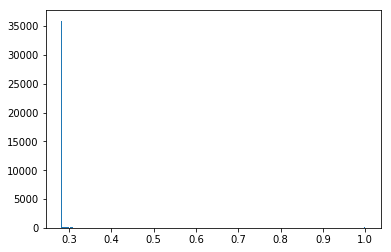

In [162]:
plt.figure()
plt.hist(img.ravel(), bins=256)
plt.show()

In [89]:
test = train.next()
X_Test = test[0][0:1]

Y_Test = test[1][0:1]
imgs_mask_test = autoencoder.predict_on_batch(X_Test)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


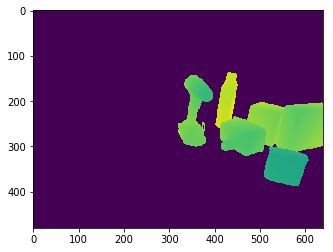

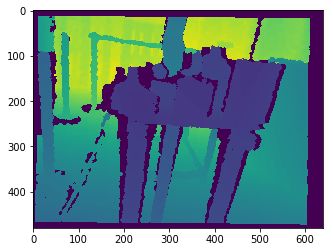

In [215]:
path = "/media/drc/DATA/chris_labelfusion/CORL2017/object_database/"
d_dir = os.listdir(path+"depth/")
gt_dir = os.listdir(path+"gtdepth/")
choice = np.random.randint(len(d_dir))
g= misc.imread(path+"gtdepth/"+gt_dir[choice])
d= misc.imread(path+"depth/"+d_dir[choice])
plt.imshow(g)
plt.figure()
plt.imshow(d)

In [216]:
g.max()

1081

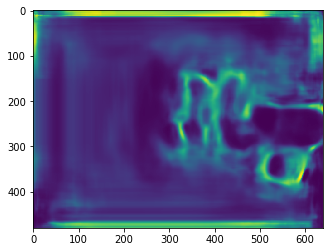

In [217]:
%matplotlib inline
gt = g/3000.
pred = autoencoder.predict_on_batch(np.reshape(gt,(1,480,640,1)))
plt.imshow(np.reshape(pred,(480,640)))

In [315]:
path  = "/media/drc/DATA/train/0/42/depth/"
img_path = path+np.random.choice(os.listdir(path))
im = misc.imread(img_path)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


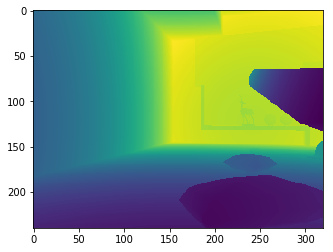

In [316]:
%matplotlib inline
plt.imshow(im)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


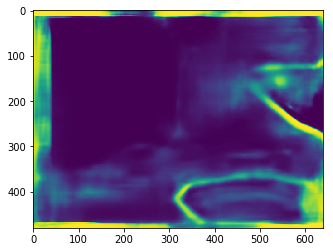

In [317]:
%matplotlib inline
im = misc.imresize(im,(480,640))/255.
pred = autoencoder.predict_on_batch(np.reshape(im,(1,480,640,1)))
plt.imshow(np.reshape(pred,(480,640)))

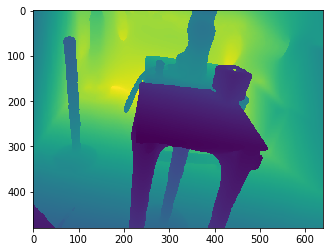

In [272]:
%matplotlib inline
img = np.reshape(X_Test[0],(480,640))
plt.imshow(img)

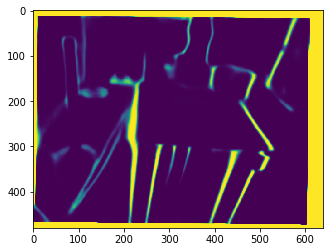

In [91]:
%matplotlib inline
img = np.reshape(imgs_mask_test[0],(480,640))
plt.imshow(img)

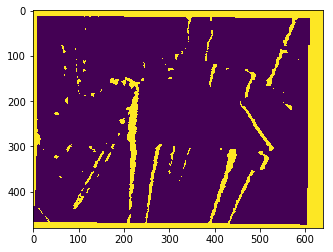

In [92]:
%matplotlib inline
img1 = np.reshape(Y_Test[0],(480,640))
plt.imshow(img1)

In [ ]:
img1 = np.copy(img)
img1[img1>.3] =1
plt.imshow(img1)